In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install seaborn

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception





import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json



2024-03-21 20:18:15.999405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 20:18:15.999515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 20:18:16.129936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')


    



Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:

epochs =20
EPOCHS =epochs





         image_id  label                              disease
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)


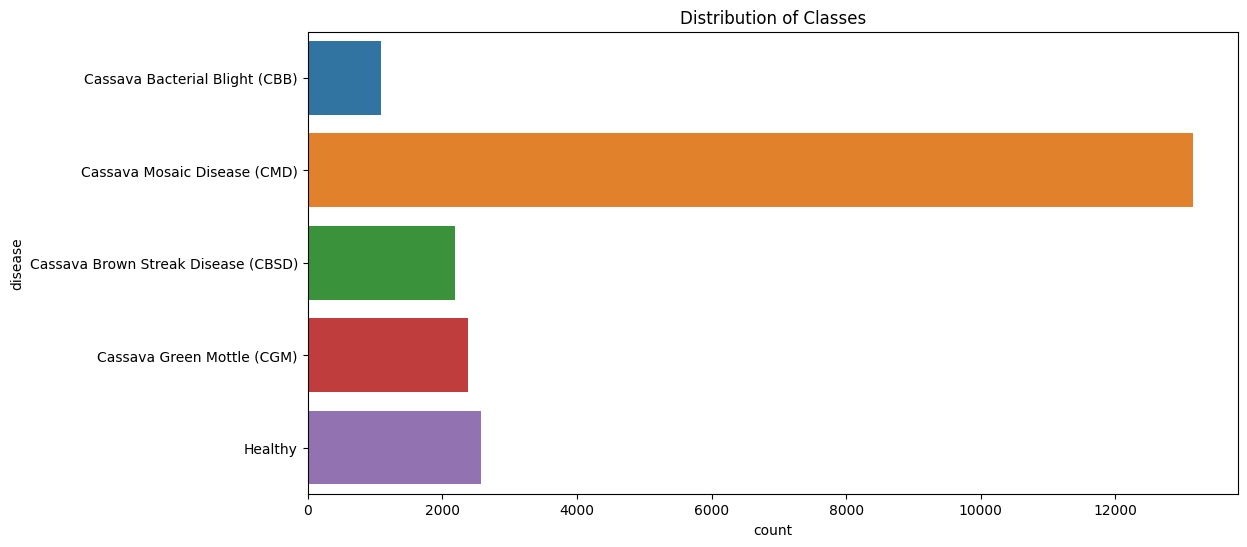

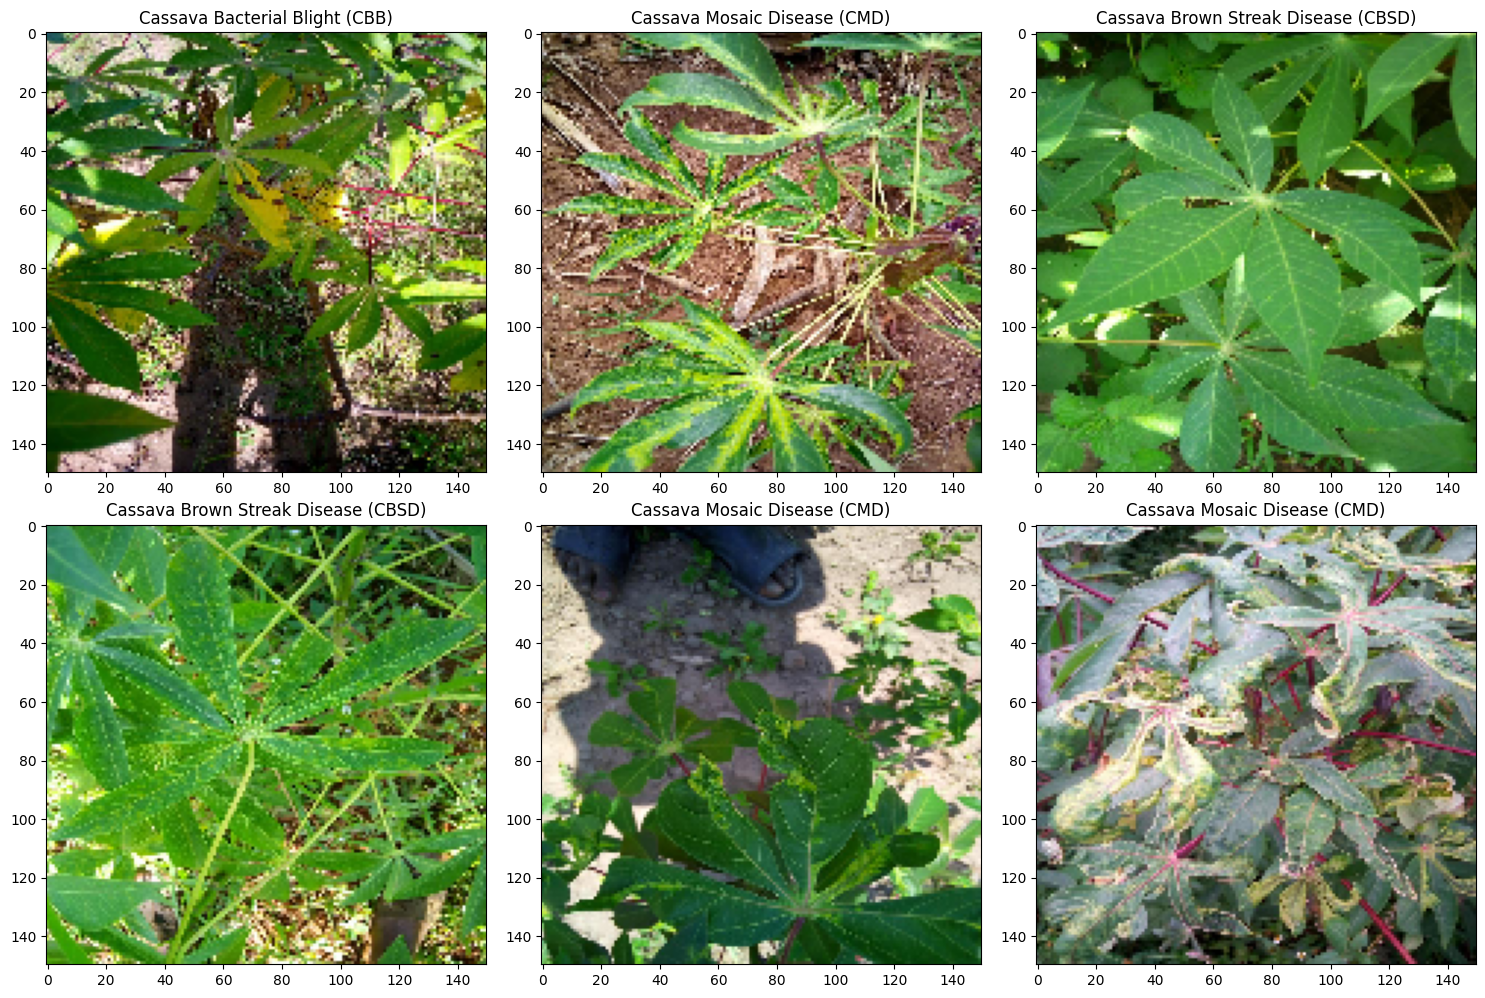

In [6]:
# Load dataset
train_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')

# Load label map
with open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as file:
    label_map = json.load(file)

# Convert label ids to disease names
train_df['disease'] = train_df['label'].astype(str).map(label_map)

# Display the first few rows
print(train_df.head())

# Visualization
plt.figure(figsize=(12, 6))
sns.countplot(y='disease', data=train_df)
plt.title('Distribution of Classes')
plt.show()

# Display some images
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    img = load_img(f"/kaggle/input/cassava-leaf-disease-classification/train_images/{train_df.iloc[i]['image_id']}", target_size=(150, 150))
    ax.imshow(img)
    ax.set_title(train_df.iloc[i]['disease'])
plt.tight_layout()

In [7]:

validation_split = 0.15

# Data Preparation
train_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
train_df['label'] = train_df['label'].astype(str)  # Convert 'label' to string


# Set up directories
train_dir = '/kaggle/input/cassava-leaf-disease-classification/train_images'
test_dir = '/kaggle/input/cassava-leaf-disease-classification/test_images'

# Split the dataset
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

# Data Generators with Preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=75,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

# Create Data Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="image_id",
    y_col="label",
    target_size=(299, 299),  # size for Xception
    batch_size=32,
    class_mode='sparse')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col="image_id",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode='sparse')



Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


In [9]:
Xception_TOP = '/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels.h5'
Xception_NOTOP = '/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(Xception_NOTOP)

/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [10]:

#  Define Model
base_model = tf.keras.applications.Xception(
    weights=Xception_NOTOP, 
    include_top=False, 
    input_shape=(299, 299, 3))



x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = Dropout(0.4)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 classes for cassava diseases

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

print(model.summary())



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


In [11]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor the validation loss
    patience=10, #number of epochs with no improvement the learning rate will be reduced
    verbose=1,    # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True)  # restore model weights from the epoch with the best value of the monitored quantity

Learning rate schedule: 1e-05 to 0.0001 to 8.72e-05


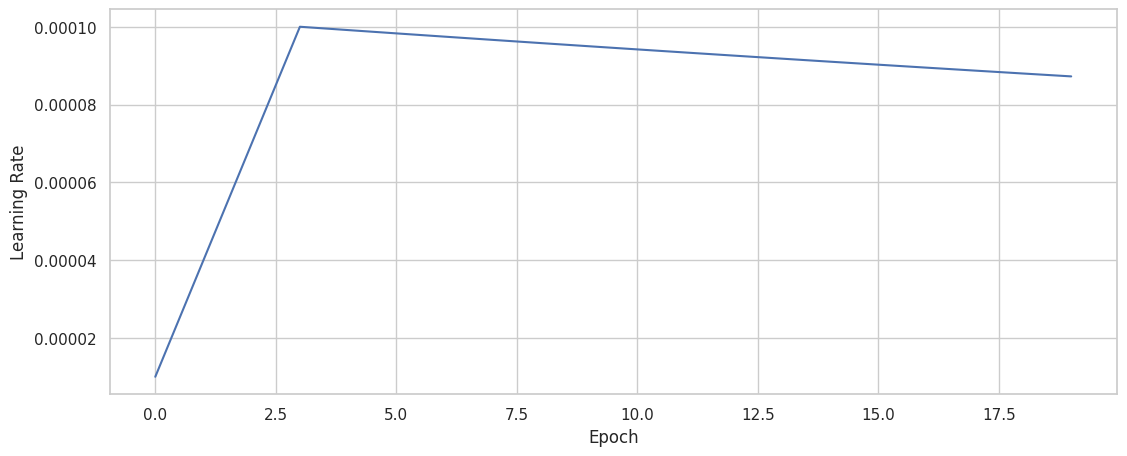

In [12]:
LR_START = 0.00001
LR_MAX = 0.0001
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.85

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(progress) + LR_MIN
    return float(lr)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,verbose=1, mode='auto',min_delta=0.0001, cooldown=0, min_lr=0)

#visualizing the learning rate schedule
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
plt.figure(figsize=(13, 5))
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [13]:
# Use a callback for learning rate scheduling //// avoiding overfitting and can be better convergence during training
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,verbose=1, mode='auto',min_delta=0.0001, cooldown=0, min_lr=0)# min_lr: meaning there is no lower limit

In [14]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)  # Save the best model

In [15]:
batch_size = 32

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping,lr_scheduler, model_checkpoint],
    verbose=1
)






Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1711052444.542638      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711052444.617993      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6147 - loss: 1.1621

W0000 00:00:1711053056.387230      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


534/534 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - accuracy: 0.6147 - loss: 1.1618 - val_accuracy: 0.4643 - val_loss: 5.2793 - learning_rate: 0.0100
Epoch 2/20
  1/534 ━━━━━━━━━━━━━━━━━━━━ 3:53 438ms/step - accuracy: 0.6562 - loss: 0.9443

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6562 - loss: 0.9443 - val_accuracy: 0.5417 - val_loss: 7.0310 - learning_rate: 0.0100
Epoch 3/20


W0000 00:00:1711053120.587744      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


534/534 ━━━━━━━━━━━━━━━━━━━━ 492s 910ms/step - accuracy: 0.6741 - loss: 0.8679 - val_accuracy: 0.6842 - val_loss: 1.3408 - learning_rate: 0.0100
Epoch 4/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 210us/step - accuracy: 0.6875 - loss: 0.7085 - val_accuracy: 0.4167 - val_loss: 3.8915 - learning_rate: 0.0100
Epoch 5/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 492s 909ms/step - accuracy: 0.7105 - loss: 0.7808 - val_accuracy: 0.6805 - val_loss: 1.0149 - learning_rate: 0.0100
Epoch 6/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 217us/step - accuracy: 0.7188 - loss: 0.6811 - val_accuracy: 0.6250 - val_loss: 1.3004 - learning_rate: 0.0100
Epoch 7/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 492s 910ms/step - accuracy: 0.7532 - loss: 0.6954 - val_accuracy: 0.2366 - val_loss: 10.6222 - learning_rate: 0.0100
Epoch 8/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 209us/step - accuracy: 0.6875 - loss: 0.8099 - val_accuracy: 0.4167 - val_loss: 4.1164 - learning_rate: 0.0100
Epoch 9/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 493s 912ms/step - accuracy: 0.7639 - los

In [16]:
# Evaluation
print('Evaluation on training set:')
model.evaluate(train_generator)

print('Evaluation on validation set:')
model.evaluate(val_generator)

Evaluation on training set:
535/535 ━━━━━━━━━━━━━━━━━━━━ 455s 851ms/step - accuracy: 0.8030 - loss: 0.6049
Evaluation on validation set:
134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - accuracy: 0.7949 - loss: 0.6600


[0.6482511758804321, 0.7957943677902222]

134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - accuracy: 0.7874 - loss: 0.6640
Validation loss: 0.6481954455375671, validation accuracy: 0.7957943677902222


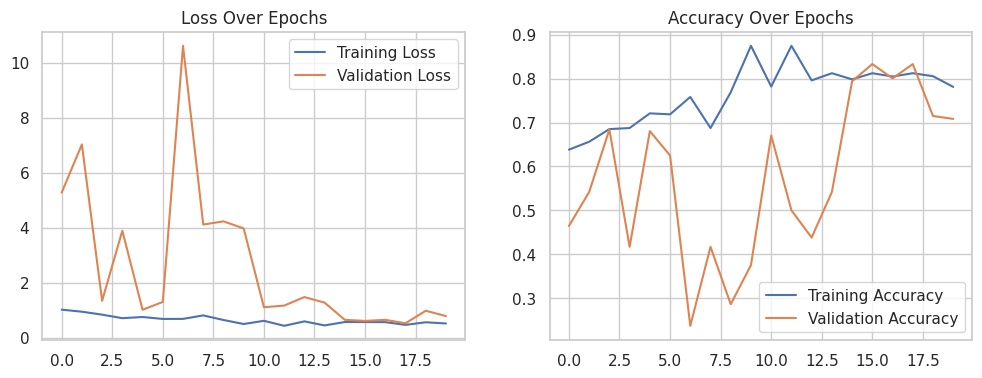

In [17]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation loss: {val_loss}, validation accuracy: {val_accuracy}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


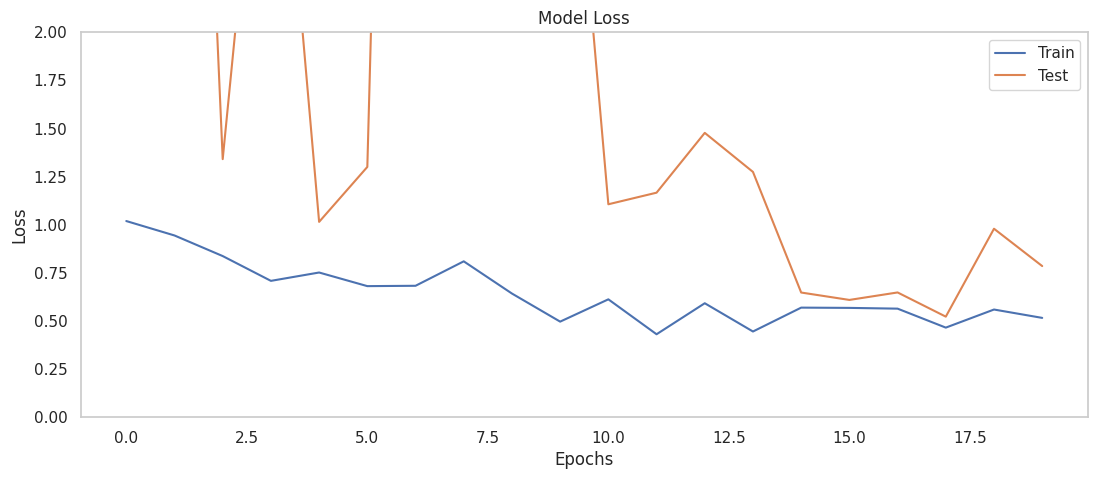

In [18]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.ylim(ymax = 2, ymin = 0)
plt.grid()
plt.show()

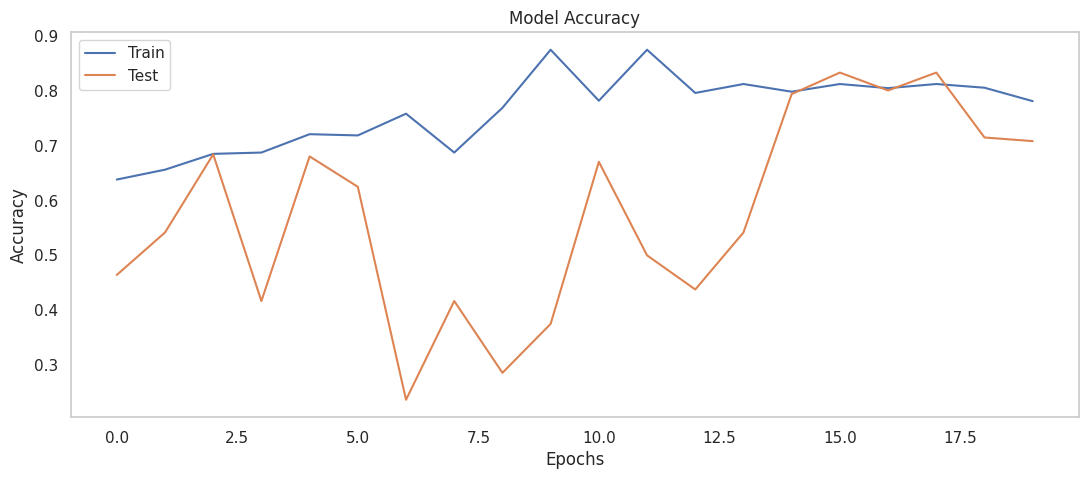

In [19]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

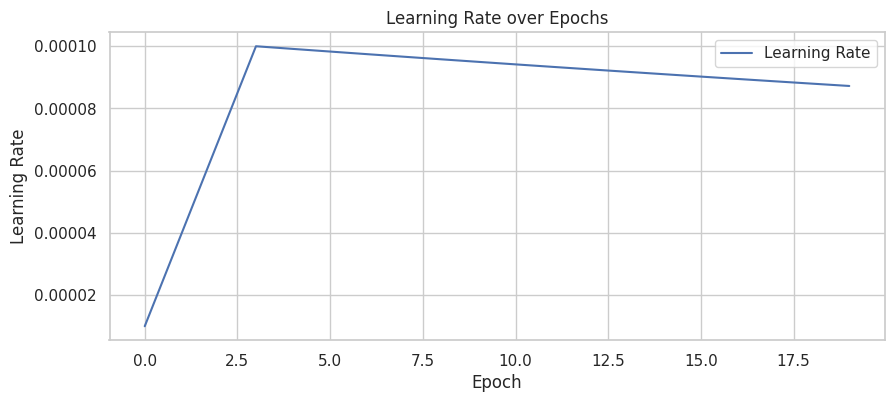

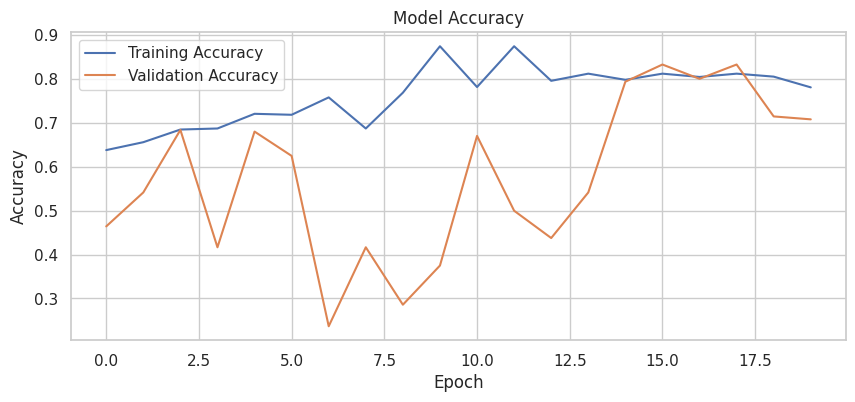

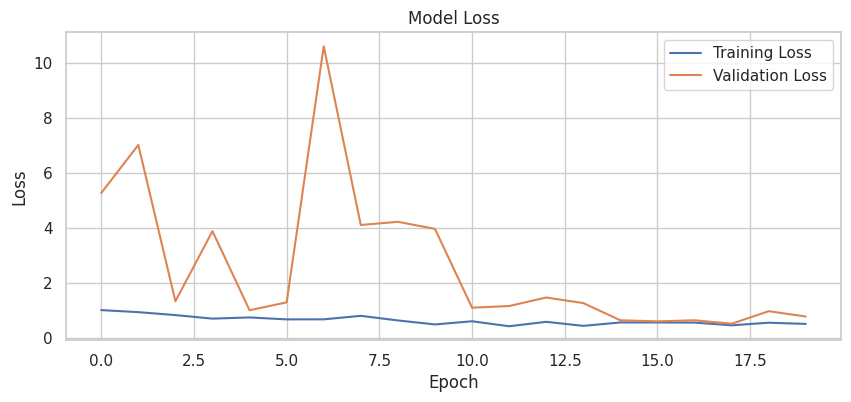

In [20]:
# Plotting learning rate
plt.figure(figsize=(10, 4))
plt.plot(history.epoch, [lrfn(epoch) for epoch in history.epoch], label='Learning Rate')
plt.title("Learning Rate over Epochs")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()